In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [3]:
from __future__ import absolute_import, division, print_function,unicode_literals
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
import tensorflow as tf
from matplotlib.ticker import (MultipleLocator)

Create the dataframe and read the Alarm Dataset of 3 years

In [4]:
df= pd.read_excel('Alarm_Final_Data.xlsx',parse_dates=[['Date','TimeStmp']])

In [5]:
df

,Date_TimeStmp,TransType,TagName
0,2018-11-19 01:27:13,InAlm,LAL-3171
1,2018-11-19 01:27:19,OutAl,LAL-3171
2,2018-11-19 04:02:26,InAlm,TAH-3485B
3,2018-11-19 04:02:58,OutAl,TAH-3485B
4,2018-11-19 04:03:08,InAlm,TAH-3485B
...,...,...,...
169079,2020-11-22 17:21:21,OutAl,LAL-3801A
169080,2020-11-22 17:37:57,InAlm,LAL-3801A
169081,2020-11-22 19:27:00,InAlm,AAH-3032
169082,2020-11-22 20:08:40,InAlm,TAL-3730A


Renaming the column names and sorting the columns 

In [7]:
df.rename(columns = {'Date_TimeStmp':'Date Timestamp'}, inplace = True)
df["Date Timestamp"] = pd.to_datetime(df["Date Timestamp"])
df = df.sort_values(['TagName', 'Date Timestamp','TransType'],
              ascending = [True, True,True])
df.reset_index(inplace=True,drop=True)

In [8]:
df

,Date Timestamp,TransType,TagName
0,2019-01-15 00:36:51,InAlm,AAH-3030
1,2019-01-15 01:02:56,OutAl,AAH-3030
2,2019-03-29 23:33:12,InAlm,AAH-3030
3,2019-03-30 01:13:43,OutAl,AAH-3030
4,2019-04-02 09:33:34,InAlm,AAH-3030
...,...,...,...
169079,2020-10-24 23:22:20,OutAl,ZA-3502
169080,2020-10-25 04:29:52,InAlm,ZA-3502
169081,2020-10-25 04:30:06,OutAl,ZA-3502
169082,2020-10-25 04:40:37,InAlm,ZA-3502


The dataset shared does not have all the "OutAlarms" entry for an "InAlm".
Creating a temporary column "Test" which has values assigned as "1" when a particular "InAlm" finds an "OutAl" and values assigned as "0" when an "InAlm" does not find a pairing with "OutAl"

In [9]:
df['Test']= np.where((df['TagName']==df['TagName'].shift(-1)) & (df['TransType']=='InAlm') 
                       & (df['TransType'].shift(-1)=='OutAl'),1,0)

In [10]:
df

,Date Timestamp,TransType,TagName,Test
0,2019-01-15 00:36:51,InAlm,AAH-3030,1
1,2019-01-15 01:02:56,OutAl,AAH-3030,0
2,2019-03-29 23:33:12,InAlm,AAH-3030,1
3,2019-03-30 01:13:43,OutAl,AAH-3030,0
4,2019-04-02 09:33:34,InAlm,AAH-3030,1
...,...,...,...,...
169079,2020-10-24 23:22:20,OutAl,ZA-3502,0
169080,2020-10-25 04:29:52,InAlm,ZA-3502,1
169081,2020-10-25 04:30:06,OutAl,ZA-3502,0
169082,2020-10-25 04:40:37,InAlm,ZA-3502,1


In [11]:
df['Test']= np.where((df['TagName']==df['TagName'].shift(1)) & (df['TransType'].shift(1)=='InAlm') 
                       & (df['TransType']=='OutAl'),1,df['Test'])

In [12]:
df

,Date Timestamp,TransType,TagName,Test
0,2019-01-15 00:36:51,InAlm,AAH-3030,1
1,2019-01-15 01:02:56,OutAl,AAH-3030,1
2,2019-03-29 23:33:12,InAlm,AAH-3030,1
3,2019-03-30 01:13:43,OutAl,AAH-3030,1
4,2019-04-02 09:33:34,InAlm,AAH-3030,1
...,...,...,...,...
169079,2020-10-24 23:22:20,OutAl,ZA-3502,1
169080,2020-10-25 04:29:52,InAlm,ZA-3502,1
169081,2020-10-25 04:30:06,OutAl,ZA-3502,1
169082,2020-10-25 04:40:37,InAlm,ZA-3502,1


Filtering the dataframe which has "Test" column value as "1"

In [13]:
df_final=df[df['Test']==1]

In [14]:
df_final

,Date Timestamp,TransType,TagName,Test
0,2019-01-15 00:36:51,InAlm,AAH-3030,1
1,2019-01-15 01:02:56,OutAl,AAH-3030,1
2,2019-03-29 23:33:12,InAlm,AAH-3030,1
3,2019-03-30 01:13:43,OutAl,AAH-3030,1
4,2019-04-02 09:33:34,InAlm,AAH-3030,1
...,...,...,...,...
169079,2020-10-24 23:22:20,OutAl,ZA-3502,1
169080,2020-10-25 04:29:52,InAlm,ZA-3502,1
169081,2020-10-25 04:30:06,OutAl,ZA-3502,1
169082,2020-10-25 04:40:37,InAlm,ZA-3502,1


In [15]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167376 entries, 0 to 169083
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date Timestamp  167376 non-null  datetime64[ns]
 1   TransType       167376 non-null  object        
 2   TagName         167376 non-null  object        
 3   Test            167376 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 6.4+ MB


In [107]:
df_final.to_excel('df_final.xlsx')

In [105]:
df_0=df[df['Test']==0]

In [106]:
df_0

,Date Timestamp,TransType,TagName,Test
334,2019-10-15 10:20:16,InAlm,AAH-3030,0
339,2019-10-19 10:18:19,InAlm,AAH-3030,0
340,2019-10-21 09:23:43,InAlm,AAH-3030,0
341,2019-10-22 11:25:24,InAlm,AAH-3030,0
342,2019-10-23 10:45:17,InAlm,AAH-3030,0
...,...,...,...,...
169059,2019-09-24 06:36:44,InAlm,ZA-3502,0
169060,2019-09-30 10:34:22,InAlm,ZA-3502,0
169061,2019-10-01 15:12:54,InAlm,ZA-3502,0
169062,2019-10-17 08:12:07,InAlm,ZA-3502,0


Creating a new column "Time_Diff" which is the time difference between an OutAl and an InAlm. "Time_Diff" will be later on renamed as "ATD"(Active Time Duration), an independent variable.

In [16]:
df_final['Time_Diff']=np.where((df_final['TagName']==df_final['TagName'].shift(-1)),
                           (df_final['Date Timestamp'].shift(-1) - df_final['Date Timestamp']).dt.seconds,0)

In [17]:
df_final

,Date Timestamp,TransType,TagName,Test,Time_Diff
0,2019-01-15 00:36:51,InAlm,AAH-3030,1,1565.0
1,2019-01-15 01:02:56,OutAl,AAH-3030,1,81016.0
2,2019-03-29 23:33:12,InAlm,AAH-3030,1,6031.0
3,2019-03-30 01:13:43,OutAl,AAH-3030,1,29991.0
4,2019-04-02 09:33:34,InAlm,AAH-3030,1,86.0
...,...,...,...,...,...
169079,2020-10-24 23:22:20,OutAl,ZA-3502,1,18452.0
169080,2020-10-25 04:29:52,InAlm,ZA-3502,1,14.0
169081,2020-10-25 04:30:06,OutAl,ZA-3502,1,631.0
169082,2020-10-25 04:40:37,InAlm,ZA-3502,1,551.0


In [18]:
df_final.reset_index(inplace=True,drop=True)
df_final=df_final[df_final['TransType']=='InAlm']
df_final.drop('TransType',axis=1,inplace=True)
df_final.drop('Test',axis=1,inplace=True)

# Dataset Preparation for Dynamic Chattering

In [22]:
df_dynamic_chattering=df_final.copy()

In [23]:
df_dynamic_chattering

,Date Timestamp,TagName,Time_Diff
0,2019-01-15 00:36:51,AAH-3030,1565.0
2,2019-03-29 23:33:12,AAH-3030,6031.0
4,2019-04-02 09:33:34,AAH-3030,86.0
6,2019-04-02 09:36:10,AAH-3030,1916.0
8,2019-04-02 15:05:50,AAH-3030,20.0
...,...,...,...
167366,2020-10-24 05:46:00,ZA-3502,14678.0
167368,2020-10-24 09:51:14,ZA-3502,3058.0
167370,2020-10-24 20:48:13,ZA-3502,9247.0
167372,2020-10-25 04:29:52,ZA-3502,14.0


For Dynamic Chattering dataset preparation, only TagName and Date Timestamp columns are needed, hence dropping off other columns

In [24]:
df_dynamic_chattering.drop('Time_Diff',axis=1,inplace=True)
df_dynamic_chattering.reset_index(inplace=True,drop=True)
n = len(pd.unique(df_dynamic_chattering['TagName']))

In [25]:
print(n)

703


Converting from Long to Wide format by pivoting

In [26]:
pivot_1 = df_dynamic_chattering.pivot(index='Date Timestamp',columns='TagName', values='TagName')

In [27]:
pivot_1

TagName,AAH-3030,AAH-3032,AAH-3040,AAH-3041,AAH-3042,AAH-3472,AAH-3521,AAH-3541,AAHH-3030,AAHH-3032,...,XV-3702B-OPEN,XV-3730-FTO,XV-3730-UCOS,XV-3732-FTC,XV-3732-FTO,XV-3732-UCOS,XV-3801D-FTO,XZSO-3151,XZSO-3251,ZA-3502
Date Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-11-19 01:27:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-19 04:02:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-19 04:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-19 04:03:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-19 04:04:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-22 16:22:40,NaN,AAH-3032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-22 16:46:43,NaN,AAH-3032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-22 17:02:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
pivot_1.reset_index(inplace=True)

In [29]:
pivot_1

TagName,Date Timestamp,AAH-3030,AAH-3032,AAH-3040,AAH-3041,AAH-3042,AAH-3472,AAH-3521,AAH-3541,AAHH-3030,...,XV-3702B-OPEN,XV-3730-FTO,XV-3730-UCOS,XV-3732-FTC,XV-3732-FTO,XV-3732-UCOS,XV-3801D-FTO,XZSO-3151,XZSO-3251,ZA-3502
0,2018-11-19 01:27:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-11-19 04:02:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-11-19 04:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-11-19 04:03:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-11-19 04:04:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79576,2020-11-22 16:22:40,NaN,AAH-3032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79577,2020-11-22 16:46:43,NaN,AAH-3032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79578,2020-11-22 17:02:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79579,2020-11-22 17:17:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
pivot_1.fillna(0,inplace=True)
pivot_1.set_index('Date Timestamp',inplace=True)
pivot_2=pivot_1[pivot_1==0].fillna(1)

In [31]:
pivot_2

TagName,AAH-3030,AAH-3032,AAH-3040,AAH-3041,AAH-3042,AAH-3472,AAH-3521,AAH-3541,AAHH-3030,AAHH-3032,...,XV-3702B-OPEN,XV-3730-FTO,XV-3730-UCOS,XV-3732-FTC,XV-3732-FTO,XV-3732-UCOS,XV-3801D-FTO,XZSO-3151,XZSO-3251,ZA-3502
Date Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-11-19 01:27:13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-11-19 04:02:26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-11-19 04:03:08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-11-19 04:03:38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-11-19 04:04:56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-22 16:22:40,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-11-22 16:46:43,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-11-22 17:02:52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# The Chattering Index by calculating the run length

In [36]:
df_run_length = pivot_2.copy()

In [37]:
df_run_length

TagName,AAH-3030,AAH-3032,AAH-3040,AAH-3041,AAH-3042,AAH-3472,AAH-3521,AAH-3541,AAHH-3030,AAHH-3032,...,XV-3702B-OPEN,XV-3730-FTO,XV-3730-UCOS,XV-3732-FTC,XV-3732-FTO,XV-3732-UCOS,XV-3801D-FTO,XZSO-3151,XZSO-3251,ZA-3502
Date Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-11-19 01:27:13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-11-19 04:02:26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-11-19 04:03:08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-11-19 04:03:38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-11-19 04:04:56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-22 16:22:40,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-11-22 16:46:43,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-11-22 17:02:52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df_run_length.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79581 entries, 2018-11-19 01:27:13 to 2020-11-22 20:08:40
Columns: 703 entries, AAH-3030 to ZA-3502
dtypes: int64(703)
memory usage: 427.4 MB


Run length is the time difference between two successive InAlarms date timestamps for the same alarm tag.

In [39]:
def calculate_run_length(df,tagname):
    df1=df[[tagname]]
    df1[tagname]=df1[tagname].astype('int')
    test1= df1[df1[tagname]==1]
    test1.reset_index(inplace=True)
    varname=tagname+'_run_length'
    test1[varname]=(test1['Date Timestamp'] - test1['Date Timestamp'].shift()).shift(-1)
    test1[varname]=test1[varname].apply(lambda x:x.total_seconds())
    test1.set_index('Date Timestamp',inplace=True)
    test1.drop(tagname,axis=1,inplace=True)
    test1.fillna(0.0,inplace=True)
    return test1

In [40]:
for i in df_run_length.columns:
    df_run_length=df_run_length.join(calculate_run_length(df_run_length,i))

In [41]:
df_run_length.fillna(0,inplace=True)

In [42]:
run_length_cols=[x for x in df_run_length.columns if  'run_length' in x]

In [43]:
run_length_df= df_run_length[run_length_cols]

In [44]:
run_length_df

TagName,AAH-3030_run_length,AAH-3032_run_length,AAH-3040_run_length,AAH-3041_run_length,AAH-3042_run_length,AAH-3472_run_length,AAH-3521_run_length,AAH-3541_run_length,AAHH-3030_run_length,AAHH-3032_run_length,...,XV-3702B-OPEN_run_length,XV-3730-FTO_run_length,XV-3730-UCOS_run_length,XV-3732-FTC_run_length,XV-3732-FTO_run_length,XV-3732-UCOS_run_length,XV-3801D-FTO_run_length,XZSO-3151_run_length,XZSO-3251_run_length,ZA-3502_run_length
Date Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-11-19 01:27:13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-19 04:02:26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-19 04:03:08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-19 04:03:38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-19 04:04:56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-22 16:22:40,0.0,1443.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-22 16:46:43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-22 17:02:52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
run_length_df[run_length_df['AAH-3030_run_length']!=0]['AAH-3030_run_length']

Date Timestamp
2019-01-15 00:36:51    6389781.0
2019-03-29 23:33:12     295222.0
2019-04-02 09:33:34        156.0
2019-04-02 09:36:10      19780.0
2019-04-02 15:05:50        692.0
                         ...    
2020-10-22 02:15:16        604.0
2020-10-22 02:25:20        200.0
2020-10-22 02:28:40       5061.0
2020-10-22 03:53:01     970120.0
2020-11-02 09:21:41       2437.0
Name: AAH-3030_run_length, Length: 1164, dtype: float64

# Run length distribution (RLD) calculation

In [46]:
np.unique(run_length_df.values).shape

(23494,)

In [47]:
run_length_distribution=pd.DataFrame(np.unique(run_length_df.values))

In [48]:
run_length_distribution.columns = ['run_length']

In [49]:
for i in run_length_df.columns:
    test=run_length_df[[i]]
    test_distribution=pd.DataFrame(np.unique(test.values))
    test_distribution.columns = ['run_length']
    xx= test_distribution.run_length.apply(lambda x: test.isin([x]).sum(axis=0))
    xx.reset_index(inplace=True)
    run_length_distribution=run_length_distribution.merge(xx,left_on='run_length',right_on='index',how='left')
    run_length_distribution.drop('index',axis=1,inplace=True)
    print('completed :',i)
run_length_distribution=run_length_distribution.fillna(0)

completed : AAH-3030_run_length
completed : AAH-3032_run_length
completed : AAH-3040_run_length
completed : AAH-3041_run_length
completed : AAH-3042_run_length
completed : AAH-3472_run_length
completed : AAH-3521_run_length
completed : AAH-3541_run_length
completed : AAHH-3030_run_length
completed : AAHH-3032_run_length
completed : AAHH-3040_run_length
completed : AAHH-3041_run_length
completed : AAHH-3042_run_length
completed : AAL-3472_run_length
completed : AIT-3472-FLT_run_length
completed : AT-3040-FLT_run_length
completed : AT-3041-FLT_run_length
completed : AT-3042-FLT_run_length
completed : DAH-3515_run_length
completed : DAHH-3515_run_length
completed : EAL-3000_run_length
completed : ESDV-3200-FTC_run_length
completed : ESDV-3200-FTO_run_length
completed : ESDV-3200-UCOS_run_length
completed : FAH-3181_run_length
completed : FAH-3380_run_length
completed : FAH-3480_run_length
completed : FAH-3547_run_length
completed : FAL-3005_run_length
completed : FAL-3020_run_length
compl

completed : LDAH-3503_run_length
completed : LDAH-3506_run_length
completed : LDAH-3516_run_length
completed : LDAH-3534_run_length
completed : LDAH-3702_run_length
completed : LDAH-3708_run_length
completed : LIT-3016-FLT_run_length
completed : LIT-3052A-FLT_run_length
completed : LIT-3052B-FLT_run_length
completed : LIT-3092-FLT_run_length
completed : LIT-3151-FLT_run_length
completed : LIT-3160-FLT_run_length
completed : LIT-3250B-FLT_run_length
completed : LIT-3385-FLT_run_length
completed : LIT-3502-FLT_run_length
completed : LIT-3503-FLT_run_length
completed : LIT-3503C-FLT_run_length
completed : LIT-3506-FLT_run_length
completed : LIT-3507-FLT_run_length
completed : LIT-3801A-FLT_run_length
completed : LIT-3801B-FLT_run_length
completed : LIT-3801C-FLT_run_length
completed : LIT-3900-FLT_run_length
completed : LSHH-3502_run_length
completed : LSHH-3523_run_length
completed : LT-3350A-FLT_run_length
completed : LT-3350B-FLT_run_length
completed : LT-3450A-FLT_run_length
completed

completed : TAH-3574B_run_length
completed : TAH-3574C_run_length
completed : TAH-3587_run_length
completed : TAH-3591_run_length
completed : TAH-3642_run_length
completed : TAH-3652_run_length
completed : TAH-3700_run_length
completed : TAH-3701_run_length
completed : TAH-3701A_run_length
completed : TAH-3711_run_length
completed : TAH-3713_run_length
completed : TAH-372_run_length
completed : TAH-3730A_run_length
completed : TAHH-3285A_run_length
completed : TAHH-3285B_run_length
completed : TAHH-3285C_run_length
completed : TAHH-3285D_run_length
completed : TAHH-3385A_run_length
completed : TAHH-3385B_run_length
completed : TAHH-3385C_run_length
completed : TAHH-3385D_run_length
completed : TAHH-3485A_run_length
completed : TAHH-3485B_run_length
completed : TAHH-3485C_run_length
completed : TAHH-3487_run_length
completed : TAHH-3533_run_length
completed : TAHH-3546_run_length
completed : TAHH-3713_run_length
completed : TAHH-3730A_run_length
completed : TAL-3020_run_length
completed

In [50]:
run_length_distribution

,run_length,AAH-3030_run_length,AAH-3032_run_length,AAH-3040_run_length,AAH-3041_run_length,AAH-3042_run_length,AAH-3472_run_length,AAH-3521_run_length,AAH-3541_run_length,AAHH-3030_run_length,...,XV-3702B-OPEN_run_length,XV-3730-FTO_run_length,XV-3730-UCOS_run_length,XV-3732-FTC_run_length,XV-3732-FTO_run_length,XV-3732-UCOS_run_length,XV-3801D-FTO_run_length,XZSO-3151_run_length,XZSO-3251_run_length,ZA-3502_run_length
0,0.0,78417.0,77130.0,79330.0,79525.0,78475.0,79576.0,79514.0,79467.0,78615.0,...,79564.0,79581.0,79581.0,79570.0,79581.0,79581.0,79574.0,79580.0,79578.0,79567.0
1,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
4,4.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23489,51789196.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23490,52817506.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23491,53942605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23492,57598442.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# Removing run_length=0 
run_length_distribution= run_length_distribution[1:]

In [52]:
run_length_distribution

,run_length,AAH-3030_run_length,AAH-3032_run_length,AAH-3040_run_length,AAH-3041_run_length,AAH-3042_run_length,AAH-3472_run_length,AAH-3521_run_length,AAH-3541_run_length,AAHH-3030_run_length,...,XV-3702B-OPEN_run_length,XV-3730-FTO_run_length,XV-3730-UCOS_run_length,XV-3732-FTC_run_length,XV-3732-FTO_run_length,XV-3732-UCOS_run_length,XV-3801D-FTO_run_length,XZSO-3151_run_length,XZSO-3251_run_length,ZA-3502_run_length
1,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
4,4.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,5.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23489,51789196.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23490,52817506.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23491,53942605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23492,57598442.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
max_alarm_count = run_length_distribution.loc[:, run_length_distribution.columns != 'run_length'].max()

In [54]:
max_alarm_count.sort_values(ascending=False)

PAH-3200_run_length        184.0
XASS-3140_run_length       171.0
FALL-3452A_run_length      152.0
FAL-3452A_run_length       152.0
FAL-3020_run_length        138.0
                           ...  
LDAH-3702_run_length         0.0
TAH-3642_run_length          0.0
LIT-3160-FLT_run_length      0.0
TAH-3487_run_length          0.0
PDAH-3387_run_length         0.0
Length: 703, dtype: float64

<AxesSubplot:xlabel='run_length'>

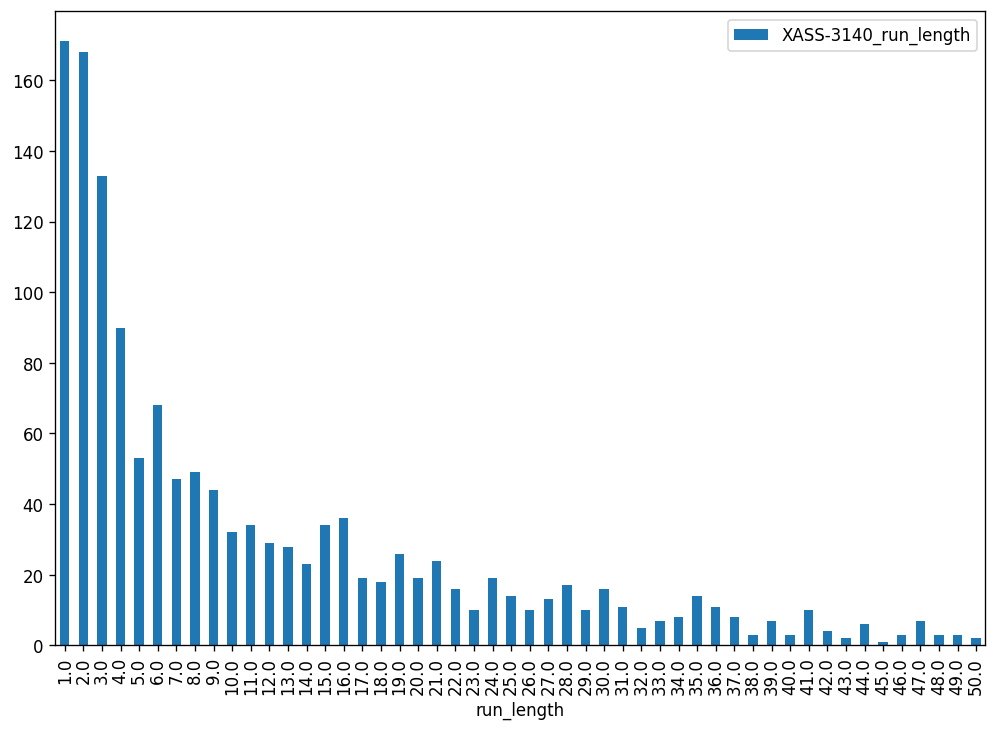

In [55]:
run_length_distribution[run_length_distribution['XASS-3140_run_length']!=0][:50].plot.bar(x = 'run_length', y = 'XASS-3140_run_length')

<AxesSubplot:xlabel='run_length'>

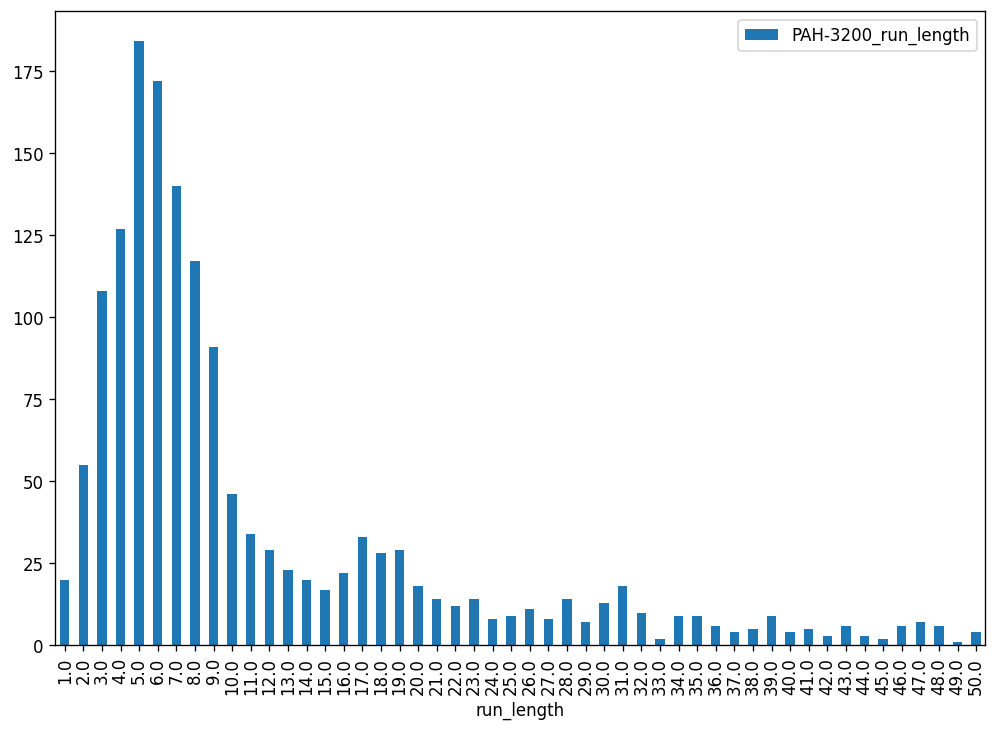

In [56]:
run_length_distribution[run_length_distribution['PAH-3200_run_length']!=0][:50].plot.bar(x = 'run_length', y = 'PAH-3200_run_length')

<AxesSubplot:xlabel='run_length'>

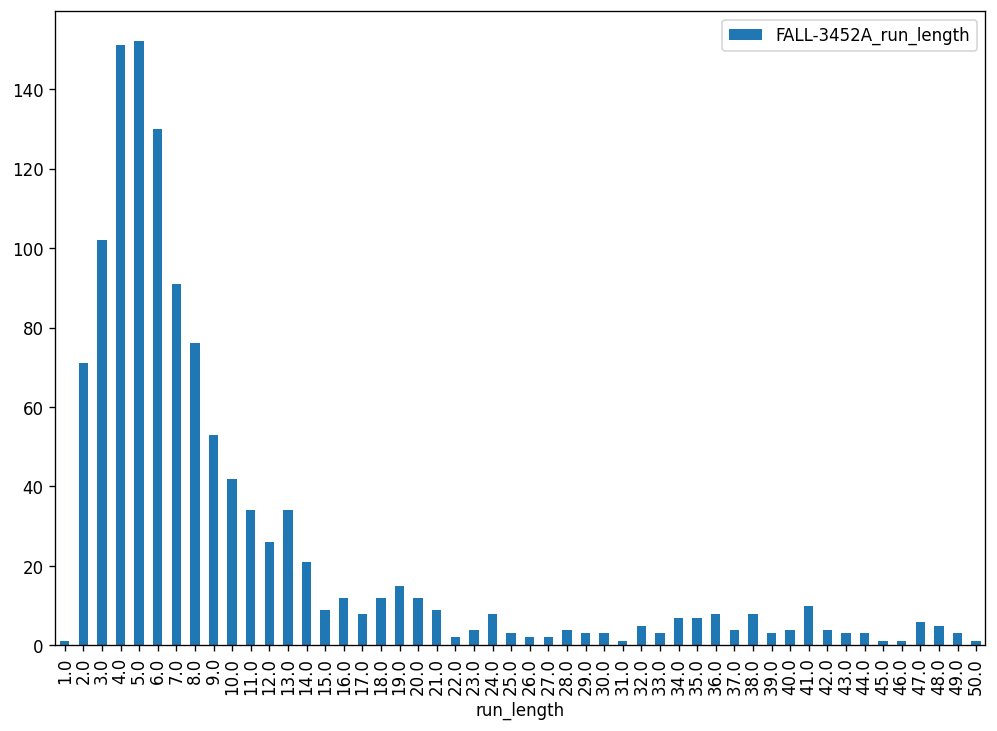

In [57]:
run_length_distribution[run_length_distribution['FALL-3452A_run_length']!=0][:50].plot.bar(x = 'run_length', y = 'FALL-3452A_run_length')

<AxesSubplot:xlabel='run_length'>

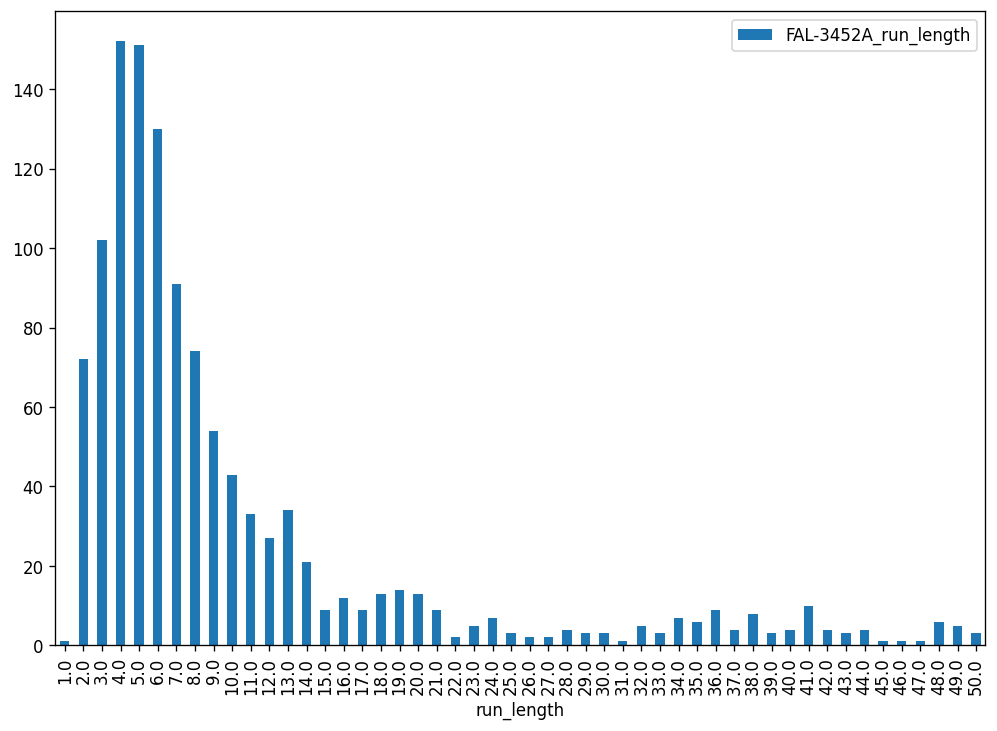

In [58]:
run_length_distribution[run_length_distribution['FAL-3452A_run_length']!=0][:50].plot.bar(x = 'run_length', y = 'FAL-3452A_run_length')

<AxesSubplot:xlabel='run_length'>

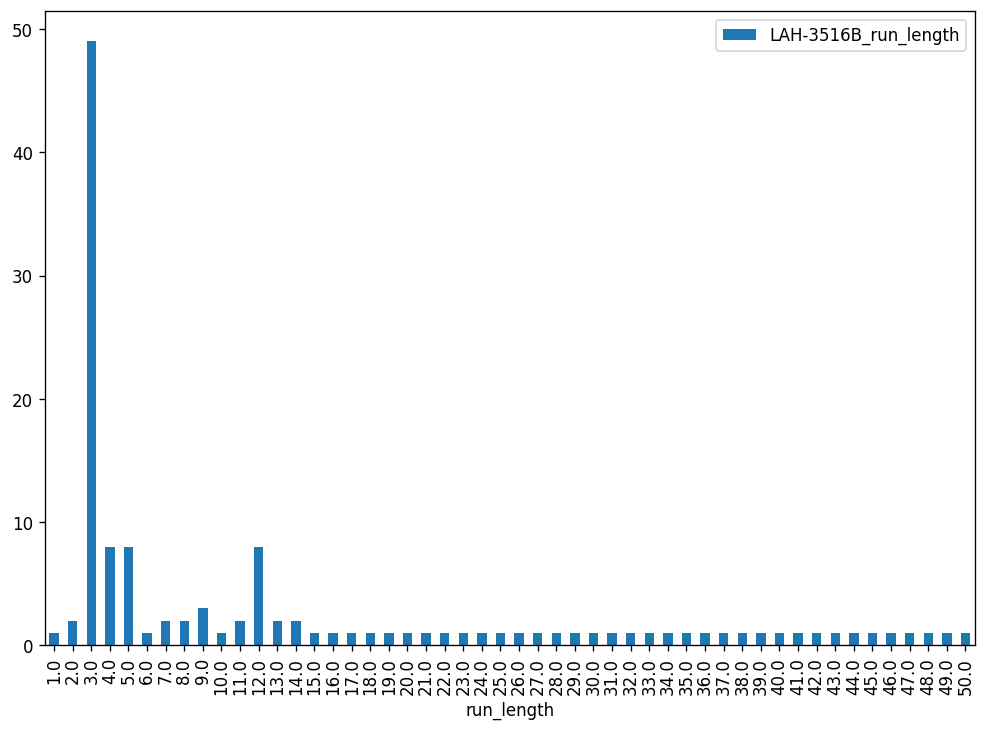

In [59]:
run_length_distribution[run_length_distribution['LAH-3516B_run_length']!=0][:50].plot.bar(x = 'run_length', y = 'LAH-3516B_run_length')

<AxesSubplot:xlabel='run_length'>

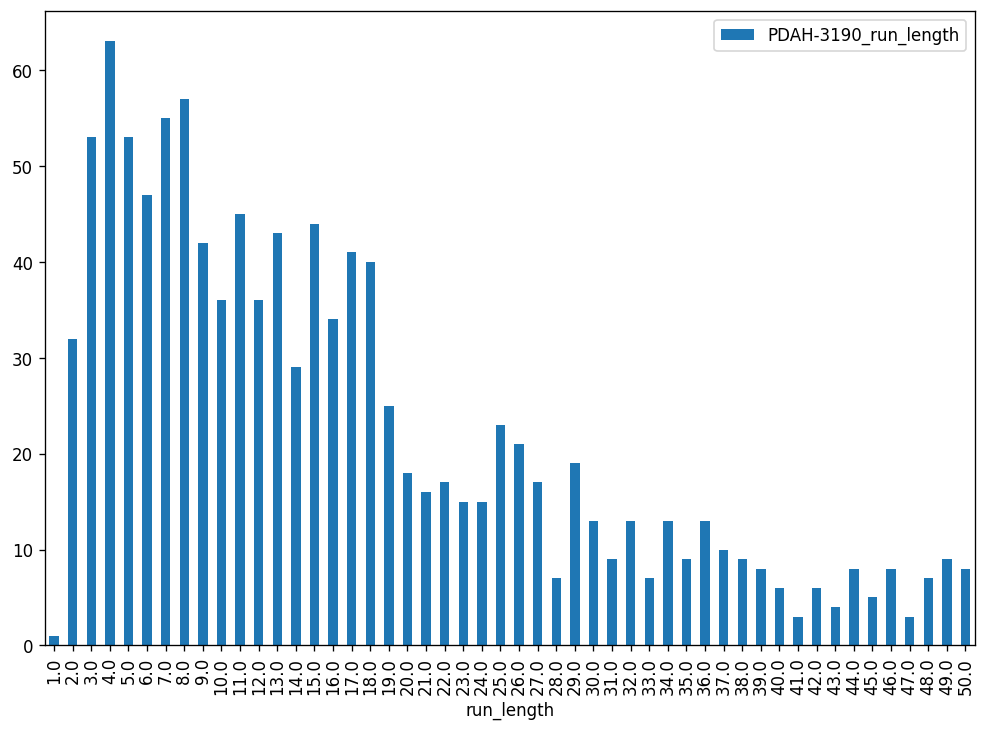

In [60]:
run_length_distribution[run_length_distribution['PDAH-3190_run_length']!=0][:50].plot.bar(x = 'run_length', y = 'PDAH-3190_run_length')

<AxesSubplot:xlabel='run_length'>

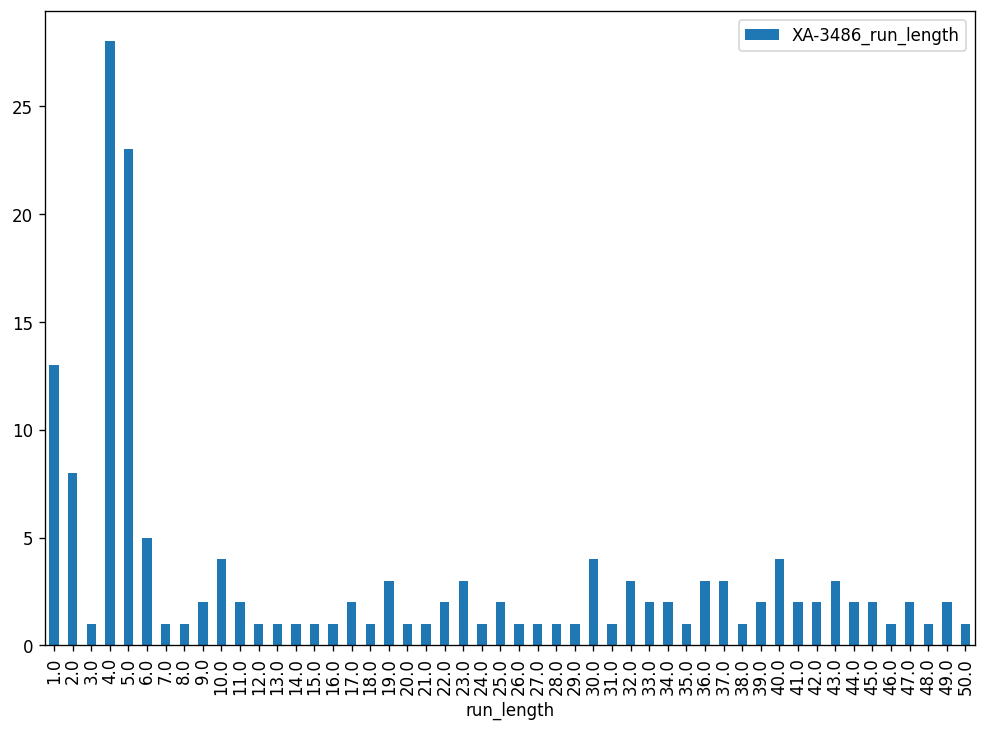

In [61]:
run_length_distribution[run_length_distribution['XA-3486_run_length']!=0][:50].plot.bar(x = 'run_length', y = 'XA-3486_run_length')

# Discrete Probability Function (DPF) calculation

In [62]:
discrete_probability_df=run_length_distribution.loc[:, run_length_distribution.columns != 'run_length'].apply(lambda x: x/x.sum())

In [63]:
discrete_probability_df.fillna(0,inplace=True)

In [64]:
discrete_probability_df=pd.concat([run_length_distribution['run_length'],discrete_probability_df],axis=1)

In [65]:
discrete_probability_df

,run_length,AAH-3030_run_length,AAH-3032_run_length,AAH-3040_run_length,AAH-3041_run_length,AAH-3042_run_length,AAH-3472_run_length,AAH-3521_run_length,AAH-3541_run_length,AAHH-3030_run_length,...,XV-3702B-OPEN_run_length,XV-3730-FTO_run_length,XV-3730-UCOS_run_length,XV-3732-FTC_run_length,XV-3732-FTO_run_length,XV-3732-UCOS_run_length,XV-3801D-FTO_run_length,XZSO-3151_run_length,XZSO-3251_run_length,ZA-3502_run_length
1,1.0,0.002577,0.000409,0.003984,0.017857,0.000904,0.2,0.014925,0.008772,0.002070,...,0.058824,0.0,0.0,0.090909,0.0,0.0,0.142857,1.0,0.333333,0.071429
2,2.0,0.000859,0.000409,0.003984,0.017857,0.000904,0.2,0.014925,0.008772,0.001035,...,0.058824,0.0,0.0,0.090909,0.0,0.0,0.142857,0.0,0.333333,0.071429
3,3.0,0.000859,0.000409,0.003984,0.017857,0.000904,0.2,0.014925,0.008772,0.001035,...,0.058824,0.0,0.0,0.090909,0.0,0.0,0.142857,0.0,0.333333,0.071429
4,4.0,0.000859,0.000409,0.003984,0.017857,0.002712,0.2,0.014925,0.008772,0.001035,...,0.058824,0.0,0.0,0.090909,0.0,0.0,0.142857,0.0,0.000000,0.071429
5,5.0,0.000859,0.001226,0.003984,0.017857,0.002712,0.2,0.014925,0.008772,0.001035,...,0.058824,0.0,0.0,0.090909,0.0,0.0,0.142857,0.0,0.000000,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23489,51789196.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
23490,52817506.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
23491,53942605.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
23492,57598442.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000


# Chattering Index

According to the definition provided in ANSI/ISA - 18.2 (2016), a nuisance alarm is: an alarm that annunciates excessively, unnecessarily, or does not return to normal after the operator action is taken. A rule of thumb to determine chattering behaviour is 3 or more alarm records (from the same alarm) in one minute, which is 0.05 alarm per second

In [66]:
discrete_probability_df['LAH-3516B_run_length'].max()

0.2076271186440678

In [67]:
( discrete_probability_df['AAH-3030_run_length'] * (1/discrete_probability_df['run_length'])).sum()

0.009592421454812866

In [68]:
( discrete_probability_df['FALL-3452A_run_length'] * (1/discrete_probability_df['run_length'])).sum()

0.1191815203089386

In [69]:
chattering_index_df= pd.DataFrame(discrete_probability_df.loc[:, discrete_probability_df.columns != 'run_length'].apply(lambda x:(x*(1/discrete_probability_df['run_length'])).sum()))

In [70]:
chattering_index_df.reset_index(inplace=True)

In [71]:
chattering_index_df.columns=['Alarm','chattering_index']

In [72]:
chattering_index_df.sort_values(by='chattering_index',ascending=False,inplace=True)

In [73]:
chattering_index_df[chattering_index_df.chattering_index > 0.05]

,Alarm,chattering_index
260,LIT-3250B-FLT_run_length,1.000000
685,XV-3471-FTC_run_length,1.000000
483,TAH-3485C_run_length,1.000000
471,TAH-3285D_run_length,1.000000
470,TAH-3285C_run_length,1.000000
...,...,...
499,TAH-3711_run_length,0.052972
199,LAL-3271_run_length,0.052694
462,TAH-3038_run_length,0.051984
139,LAH-3450_run_length,0.051177


Alarm PAL-3190_run_length, PAH-3190_run_length and LAL-3502_run_length are predicted as chattering because of the limitation of chattering index. which is : Dynamic chattering index is sensitive to “high probability–short run lengths” combinations and, in certain circumstances, it may behave in an unexpected way

<AxesSubplot:xlabel='run_length'>

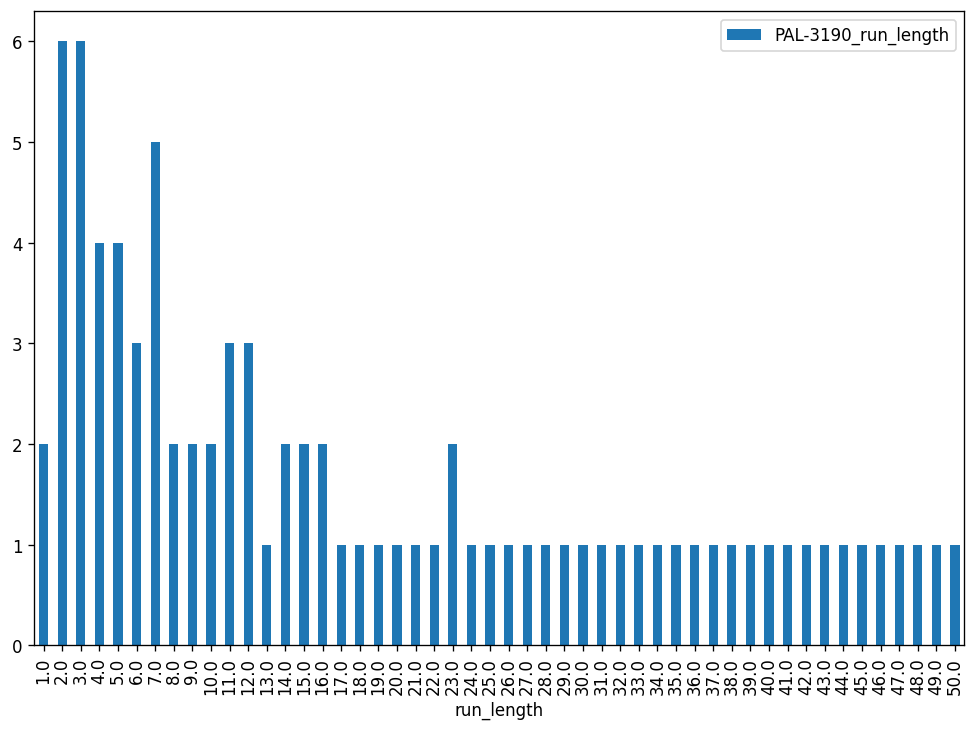

In [74]:
run_length_distribution[run_length_distribution['PAL-3190_run_length']!=0][:50].plot.bar(x = 'run_length', y = 'PAL-3190_run_length')

<AxesSubplot:xlabel='run_length'>

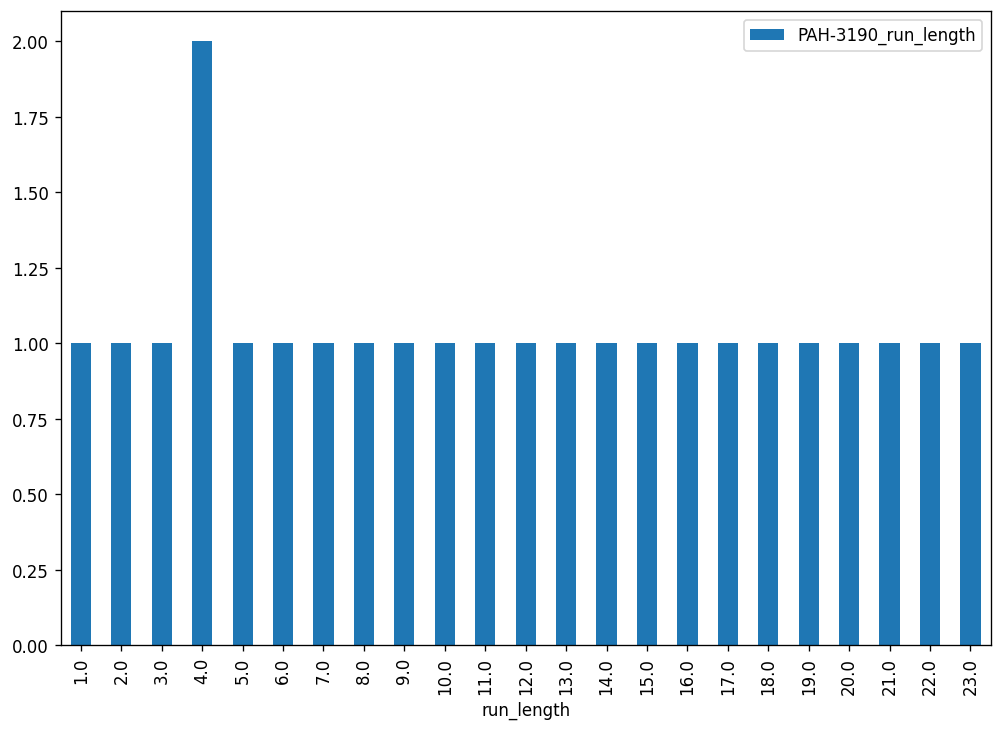

In [75]:
run_length_distribution[run_length_distribution['PAH-3190_run_length']!=0][:50].plot.bar(x = 'run_length', y = 'PAH-3190_run_length')

# Dynamic Chattering Index

In [76]:
def calculate_run_length1(df,tagname):
    df1=df[[tagname]]
    df1[tagname]=df1[tagname].astype('int')
    test1= df1[df1[tagname]==1]
    test1.reset_index(inplace=True)
    varname=tagname+'_run_length'
    test1[varname]=(test1['Date Timestamp'] - test1['Date Timestamp'].shift()).shift(-1)
    test1[varname]=test1[varname].apply(lambda x:x.total_seconds())
    test1.set_index('Date Timestamp',inplace=True)
    test1.drop(tagname,axis=1,inplace=True)
    test1.fillna(0.0,inplace=True)
    run_length_distribution=pd.DataFrame(np.unique(test1.values))
    run_length_distribution.columns = ['run_length']
    xx= run_length_distribution.run_length.apply(lambda x: test1.isin([x]).sum(axis=0))
    run_length_distribution = pd.concat([run_length_distribution,xx],axis=1)
    run_length_distribution= run_length_distribution[1:]
    discrete_probability_df=run_length_distribution.loc[:, run_length_distribution.columns != 'run_length'].apply(lambda x: x/x.sum())
    discrete_probability_df.fillna(0,inplace=True)
    discrete_probability_df=pd.concat([run_length_distribution['run_length'],discrete_probability_df],axis=1)
    chattering_index_df= pd.DataFrame(discrete_probability_df.loc[:, discrete_probability_df.columns != 'run_length'].apply(lambda x:(x*(1/discrete_probability_df['run_length'])).sum()))
    chattering_index_df.reset_index(inplace=True)
    return chattering_index_df

def dynamic_chattering(df_dynamic,tagname):
    df_dynamic=df_dynamic[df_dynamic[tagname]==1]
    out_df=pd.DataFrame()
    for i in range(len(df_dynamic)):
        next_hour= df_dynamic.iloc[i][0] + pd.DateOffset(hours=1)
        cur_hour= df_dynamic.iloc[i][0]
        test2 = df_dynamic[(df_dynamic['Date Timestamp'] >= cur_hour) & (df_dynamic['Date Timestamp'] <= next_hour)]
        test2.reset_index(drop=True,inplace=True)
        test2.set_index('Date Timestamp',inplace=True)
        if out_df.empty:
            dict={'Date Timestamp':df_dynamic.iloc[i][0],'dynamic_chattering':calculate_run_length1(test2,tagname)[0] }
            temp = pd.DataFrame(dict)
            temp.columns=['Date Timestamp',tagname]
            out_df = temp.copy()
        else:
            out_df.loc[len(out_df.index)] = [df_dynamic.iloc[i][0],calculate_run_length1(test2,tagname)[0][0]]
    out_df.set_index('Date Timestamp',inplace=True)
    return out_df

In [77]:
dynamic_chatt_df =  pivot_2.copy()

In [78]:
dynamic_chatt_df.columns[1:]

Index(['AAH-3032', 'AAH-3040', 'AAH-3041', 'AAH-3042', 'AAH-3472', 'AAH-3521',
       'AAH-3541', 'AAHH-3030', 'AAHH-3032', 'AAHH-3040',
       ...
       'XV-3702B-OPEN', 'XV-3730-FTO', 'XV-3730-UCOS', 'XV-3732-FTC',
       'XV-3732-FTO', 'XV-3732-UCOS', 'XV-3801D-FTO', 'XZSO-3151', 'XZSO-3251',
       'ZA-3502'],
      dtype='object', name='TagName', length=702)

In [79]:
dynamic_chatt_df

TagName,AAH-3030,AAH-3032,AAH-3040,AAH-3041,AAH-3042,AAH-3472,AAH-3521,AAH-3541,AAHH-3030,AAHH-3032,...,XV-3702B-OPEN,XV-3730-FTO,XV-3730-UCOS,XV-3732-FTC,XV-3732-FTO,XV-3732-UCOS,XV-3801D-FTO,XZSO-3151,XZSO-3251,ZA-3502
Date Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-11-19 01:27:13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-11-19 04:02:26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-11-19 04:03:08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-11-19 04:03:38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-11-19 04:04:56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-22 16:22:40,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-11-22 16:46:43,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-11-22 17:02:52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
dynamic_chatt_df.reset_index(inplace=True)

In [81]:
dynamic_chatt_df['Date Timestamp'] = pd.to_datetime(dynamic_chatt_df['Date Timestamp'])

In [82]:
dynamic_chattering_df=dynamic_chatt_df[['Date Timestamp']]
dynamic_chattering_df.set_index('Date Timestamp',inplace=True)
for i in dynamic_chatt_df.columns[1:]:
    dynamic_chattering_df=dynamic_chattering_df.join(dynamic_chattering(dynamic_chatt_df,i))
    print('Completed ',i)

Completed  AAH-3030
Completed  AAH-3032
Completed  AAH-3040
Completed  AAH-3041
Completed  AAH-3042
Completed  AAH-3472
Completed  AAH-3521
Completed  AAH-3541
Completed  AAHH-3030
Completed  AAHH-3032
Completed  AAHH-3040
Completed  AAHH-3041
Completed  AAHH-3042
Completed  AAL-3472
Completed  AIT-3472-FLT
Completed  AT-3040-FLT
Completed  AT-3041-FLT
Completed  AT-3042-FLT
Completed  DAH-3515
Completed  DAHH-3515
Completed  EAL-3000
Completed  ESDV-3200-FTC
Completed  ESDV-3200-FTO
Completed  ESDV-3200-UCOS
Completed  FAH-3181
Completed  FAH-3380
Completed  FAH-3480
Completed  FAH-3547
Completed  FAL-3005
Completed  FAL-3020
Completed  FAL-3030
Completed  FAL-3051A
Completed  FAL-3052A
Completed  FAL-3110
Completed  FAL-3126A
Completed  FAL-3181
Completed  FAL-3187A
Completed  FAL-3187B
Completed  FAL-3187C
Completed  FAL-3187D
Completed  FAL-3187E
Completed  FAL-3187F
Completed  FAL-3281
Completed  FAL-3287A
Completed  FAL-3287B
Completed  FAL-3287C
Completed  FAL-3287D
Completed  F

Completed  PM-3038-FLT
Completed  PM-3049-FLT
Completed  PM-3049-FTS
Completed  PM-3050-FLT
Completed  PM-3050-FTS
Completed  PM-3051-FLT
Completed  PM-3051-FTS
Completed  PM-3052-FLT
Completed  PM-3052-FTS
Completed  PM-3100-FLT
Completed  PM-3101-FLT
Completed  PM-3101-FTP
Completed  PM-3102-FLT
Completed  PM-3102-FTP
Completed  PM-3109-FLT
Completed  PM-3109-FTS
Completed  PM-3110-FLT
Completed  PM-3110-FTS
Completed  PM-3123-FLT
Completed  PM-3124-FLT
Completed  PM-3126A-FLT
Completed  PM-3126B-FLT
Completed  PM-3126B-FTS
Completed  PM-3131-FLT
Completed  PM-3132-FLT
Completed  PM-3133-FLT
Completed  PM-3134-FLT
Completed  PM-3136-FLT
Completed  PM-3137-FLT
Completed  PM-3139-FLT
Completed  PM-3140-FLT
Completed  PM-3141-FLT
Completed  PM-3142-FLT
Completed  PM-3144-FLT
Completed  PM-3182-FLT
Completed  PM-3251-FTP
Completed  PM-3251-FTS
Completed  PM-3252-FTS
Completed  PM-3354-FLT
Completed  PM-3360-FLT
Completed  PM-3451A-FLT
Completed  PM-3451B-FLT
Completed  PM-3451B-FTP
Compl

In [83]:
# -1 corresponnds to timestamp when alarm was not active
dynamic_chattering_df.fillna(-1,inplace=True)

In [84]:
dynamic_chattering_df

,AAH-3030,AAH-3032,AAH-3040,AAH-3041,AAH-3042,AAH-3472,AAH-3521,AAH-3541,AAHH-3030,AAHH-3032,...,XV-3702B-OPEN,XV-3730-FTO,XV-3730-UCOS,XV-3732-FTC,XV-3732-FTO,XV-3732-UCOS,XV-3801D-FTO,XZSO-3151,XZSO-3251,ZA-3502
Date Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-11-19 01:27:13,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2018-11-19 04:02:26,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2018-11-19 04:03:08,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2018-11-19 04:03:38,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2018-11-19 04:04:56,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-22 16:22:40,-1.0,0.000693,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2020-11-22 16:46:43,-1.0,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2020-11-22 17:02:52,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [85]:
dynamic_chattering_df_updated = dynamic_chattering_df.copy()

In [146]:
# def assign_CHB(df):
#     for i in range(dynamic_chattering_df_updated.shape[0]):
#         for j in range(dynamic_chattering_df_updated.shape[1]):
#             if (dynamic_chattering_df_updated.iat[i,j]) != -1:
#                 if (dynamic_chattering_df_updated.iat[i,j]) >=0.05:
#                     dynamic_chattering_df_updated.iat[i,j]=1
#                 else:
#                     dynamic_chattering_df_updated.iat[i,j]=0

#     return df

Assigning 1 to the alarms which has dynamic chattering index greater than 0.05 and assigning 0 to the alarms which has dynamic chattering index lesser than 0.05 and -1 to the cells where an alarm has not occured for a particular date timestamp

In [86]:
def assign_CHB(df):
    for i in df.columns:
        df[i]=np.where(df[i]!=-1,np.where(df[i] >= 0.05,1,0),df[i])
    return df

dynamic_chattering_df_updated= assign_CHB(dynamic_chattering_df_updated)

In [87]:
assign_CHB(dynamic_chattering_df_updated)

,AAH-3030,AAH-3032,AAH-3040,AAH-3041,AAH-3042,AAH-3472,AAH-3521,AAH-3541,AAHH-3030,AAHH-3032,...,XV-3702B-OPEN,XV-3730-FTO,XV-3730-UCOS,XV-3732-FTC,XV-3732-FTO,XV-3732-UCOS,XV-3801D-FTO,XZSO-3151,XZSO-3251,ZA-3502
Date Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-11-19 01:27:13,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2018-11-19 04:02:26,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2018-11-19 04:03:08,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2018-11-19 04:03:38,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2018-11-19 04:04:56,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-22 16:22:40,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2020-11-22 16:46:43,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2020-11-22 17:02:52,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [88]:
dynamic_chattering_df_updated

,AAH-3030,AAH-3032,AAH-3040,AAH-3041,AAH-3042,AAH-3472,AAH-3521,AAH-3541,AAHH-3030,AAHH-3032,...,XV-3702B-OPEN,XV-3730-FTO,XV-3730-UCOS,XV-3732-FTC,XV-3732-FTO,XV-3732-UCOS,XV-3801D-FTO,XZSO-3151,XZSO-3251,ZA-3502
Date Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-11-19 01:27:13,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2018-11-19 04:02:26,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2018-11-19 04:03:08,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2018-11-19 04:03:38,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2018-11-19 04:04:56,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-22 16:22:40,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2020-11-22 16:46:43,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2020-11-22 17:02:52,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [89]:
dynamic_chattering_df_updated.reset_index(inplace=True)

In [90]:
col_df=dynamic_chattering_df_updated.columns[1:]

In [91]:
col_df

Index(['AAH-3030', 'AAH-3032', 'AAH-3040', 'AAH-3041', 'AAH-3042', 'AAH-3472',
       'AAH-3521', 'AAH-3541', 'AAHH-3030', 'AAHH-3032',
       ...
       'XV-3702B-OPEN', 'XV-3730-FTO', 'XV-3730-UCOS', 'XV-3732-FTC',
       'XV-3732-FTO', 'XV-3732-UCOS', 'XV-3801D-FTO', 'XZSO-3151', 'XZSO-3251',
       'ZA-3502'],
      dtype='object', length=703)

Converting from wide to long format

In [92]:
xx = pd.melt(dynamic_chattering_df_updated,id_vars='Date Timestamp',value_vars=col_df)

In [93]:
xx

,Date Timestamp,variable,value
0,2018-11-19 01:27:13,AAH-3030,-1.0
1,2018-11-19 04:02:26,AAH-3030,-1.0
2,2018-11-19 04:03:08,AAH-3030,-1.0
3,2018-11-19 04:03:38,AAH-3030,-1.0
4,2018-11-19 04:04:56,AAH-3030,-1.0
...,...,...,...
55945438,2020-11-22 16:22:40,ZA-3502,-1.0
55945439,2020-11-22 16:46:43,ZA-3502,-1.0
55945440,2020-11-22 17:02:52,ZA-3502,-1.0
55945441,2020-11-22 17:17:38,ZA-3502,-1.0


In [94]:
xx['value'].sum()

-55847864.0

In [97]:
xx['value'] = xx['value'].astype(str)

Filtering out all -1 values from value column, leaving only 0's and 1's

In [99]:
xx=xx[xx['value'] != '-1.0']

In [100]:
xx

,Date Timestamp,variable,value
5043,2019-01-15 00:36:51,AAH-3030,0.0
12939,2019-03-29 23:33:12,AAH-3030,0.0
13558,2019-04-02 09:33:34,AAH-3030,0.0
13559,2019-04-02 09:36:10,AAH-3030,0.0
13570,2019-04-02 15:05:50,AAH-3030,0.0
...,...,...,...
55940324,2020-10-24 05:46:00,ZA-3502,0.0
55940381,2020-10-24 09:51:14,ZA-3502,0.0
55940445,2020-10-24 20:48:13,ZA-3502,0.0
55940520,2020-10-25 04:29:52,ZA-3502,0.0


In [101]:
xx.to_excel('xx.xlsx')

In [104]:
df_final.to_excel('df_final.xlsx')

After downloading both the datasets(xx,df_final), add value column from xx.xlsx to df_final.xlsx dataset which will be the target variable and that's the final dataset for feeding into the model